# Clasificacion Automatica de Tickets con NLP

### Integrantes
* Katty Ode Paton(katty.ode@gmail.com)
* Daniel Olivera (3daniel.olivera@gmail.com)
* Maria Lucero Yañez Guzman (lyanezguz@gmail.com)

## Descripcion del Problema

Debe crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, puede segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, podrá asignar cada ticket a su respectivo departamento/categoría. Luego puede usar estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, puede clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

In [1]:
## mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Flujo de Trajajo a Realizar:

Debe realizar las siguientes ocho tareas principales para completar la tarea:

1. Data Loading

2. Text preprocessing

3. Exploratory Data Analysis (EDA)

4. Feature Extraction

5. Topic modeling

6. Model building using Supervised Learning

7. Model training and evaluation

8. Model inference

## Setup e Importacion de Librerias

In [2]:
## SpaCy and en_core_web_sm installation
!pip install spacy

##run the following command in the console
#python -m spacy download en_core_web_sm

## Importing the necessary libraries

In [3]:
import json
import numpy as np
import pandas as pd
import re, string

# Import NLTK libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Import Spacy libraries
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Loading the data

Los datos están en formato JSON y necesitamos convertirlos a un dataframe.

In [5]:
with open('/content/drive/MyDrive/_data/complaints.json') as f:
    data = json.load(f)

# Normalize JSON data
df = pd.json_normalize(data)

## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
#print the column names
column_names = df.columns
print(column_names)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [8]:
#Assign new column names
# Define a dictionary to map old column names to new column names
column_mapping = {'_index': 'index', '_type':'type', '_id':'id', '_score':'score', '_source.tags':'tags', '_source.zip_code':'zip_code',
       '_source.complaint_id':'complaint_id', '_source.issue':'issue', '_source.date_received':'date_received',
       '_source.state':'state', '_source.consumer_disputed':'consumer_disputed', '_source.product':'product',
       '_source.company_response':'company_response', '_source.company':'company', '_source.submitted_via':'submitted_via',
       '_source.date_sent_to_company':'date_sent_to_company', '_source.company_public_response':'company_public_response',
       '_source.sub_product':'sub_product', '_source.timely':'timely',
       '_source.complaint_what_happened':'complaint', '_source.sub_issue':'sub_issue',
       '_source.consumer_consent_provided':'consumer_consent_provided'}

# Use the rename() method to rename the columns
df.rename(columns=column_mapping, inplace=True)

In [9]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [10]:
#Assign nan in place of blanks in the complaints column
# Replace blanks with NaN in the specified column
df['complaint'] = df['complaint'].replace('', np.nan)

# Print the DataFrame
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A


In [11]:
df.shape

(78313, 22)

In [12]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint'])

In [13]:
df.shape

(21072, 22)

In [14]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Una vez que haya eliminado todas las quejas en blanco, debe:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers

Una vez que haya realizado estas operaciones de limpieza, debe realizar lo siguiente:

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def data_processing(text):
  #Make the text lowercase
    text = text.lower()
  #Remove text in square brackets using regular expressions
    text = re.sub(r'\[.*?\]', '', text)
  #Remove punctuation using regular expressions
    text = re.sub(r'[^\w\s]', '', text)
   # Remove words containing numbers using regular expressions
    text = re.sub(r'\w*\d\w*', '', text)
    return text

In [16]:
# Apply the processing function to the DataFrame's column
df['complaint'] = df['complaint'].apply(data_processing)

In [17]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told ...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket ...,Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it i...,Funds not handled or disbursed as instructed,Consent provided


In [18]:
# Write your function to Lemmatize the texts
# Define a function to perform lemmatization
def lemmatize_text(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatize each word in the text
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Join the lemmatized words back into a string
    lemmatized_text = ' '.join(lemmatized_words)

    return lemmatized_text

In [19]:
df['lemmatized_complaint'] = df['complaint'].apply(lemmatize_text)

In [20]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[['complaint', 'lemmatized_complaint']]

In [21]:
df_clean.head()

,complaint,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...


In [22]:
df_clean

,complaint,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...
...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...


In [23]:
df_clean.shape

(21072, 2)

In [24]:
# Function to extract POS tags and filter for nouns ("NN")
def _pos_tags(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Use NLTK's POS tagging to tag each word with its POS
    pos_tags = nltk.pos_tag(words)

    # Filter for nouns ("NN") Noun singular
    nouns = [word for word, tag in pos_tags if tag in ['NN']]

    # Join the filtered nouns back into a string
    filtered_text = ' '.join(nouns)

    return filtered_text

In [25]:
df_clean['complaint_POS_removed'] = df_clean['lemmatized_complaint'].apply(_pos_tags) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"]

In [26]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...
...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...


## Exploratory data analysis to get familiar with the data.

Escriba el código en esta tarea para realizar lo siguiente:

* Visualiza los datos según la longitud del carácteres 'Complaint'
* Usando una nube de palabras, encuentre las top 40 palabras más frecuentes de todos los artículos después de procesar el texto
* Encuentre los mejores unigramas, bigramas y trigramas por frecuencia entre todas las quejas después de procesar el texto. '

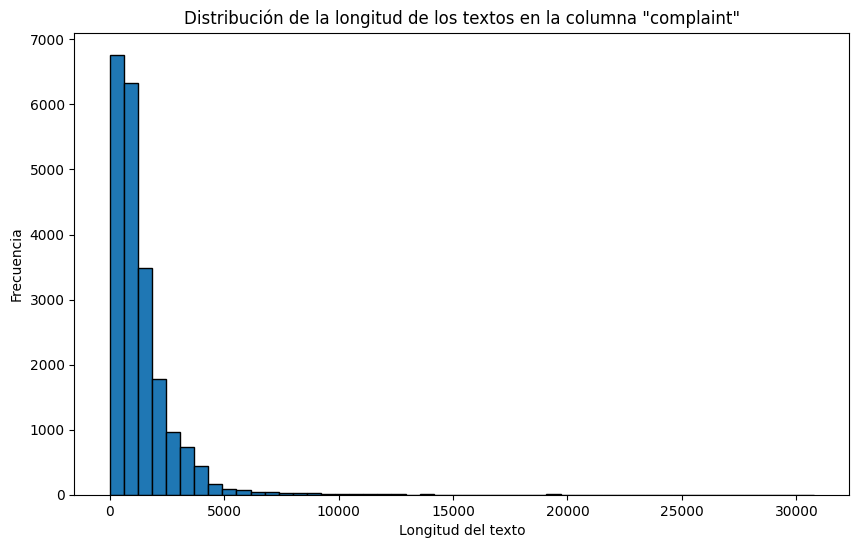

In [27]:
# Write your code here to visualise the data according to the 'Complaint' character length
import matplotlib.pyplot as plt

# Calcular la longitud de cada texto en la columna "complaint"
df_clean['complaint_length'] = df_clean['complaint'].apply(len)

# Crear un gráfico de barras para visualizar la distribución
plt.figure(figsize=(10, 6))
plt.hist(df_clean['complaint_length'], bins=50, edgecolor='k')
plt.title('Distribución de la longitud de los textos en la columna "complaint"')
plt.xlabel('Longitud del texto')
plt.ylabel('Frecuencia')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [28]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

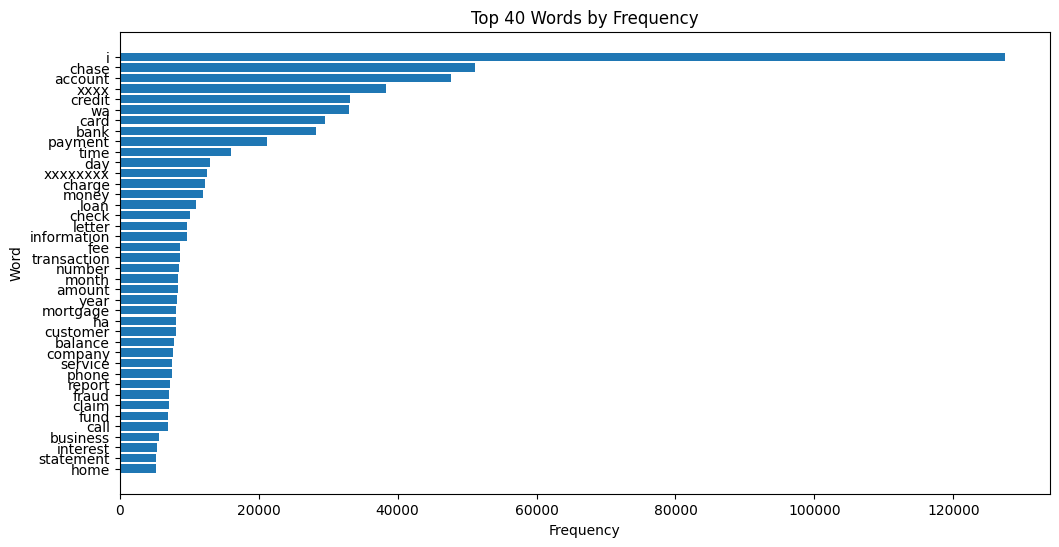

In [29]:
# Combine all the articles into a single string
all_text = ' '.join(df_clean['complaint_POS_removed'])

# Tokenize the combined text into words
words = word_tokenize(all_text)

# Calculate word frequencies
word_freq = FreqDist(words)

# Get the top 40 words by frequency
top_40_words = word_freq.most_common(40)

# Create a DataFrame for visualization
top_40_df = pd.DataFrame(top_40_words, columns=['Word', 'Frequency'])

# Plot the top 40 words
plt.figure(figsize=(12, 6))
plt.barh(top_40_df['Word'], top_40_df['Frequency'])
plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent words at the top
plt.title('Top 40 Words by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

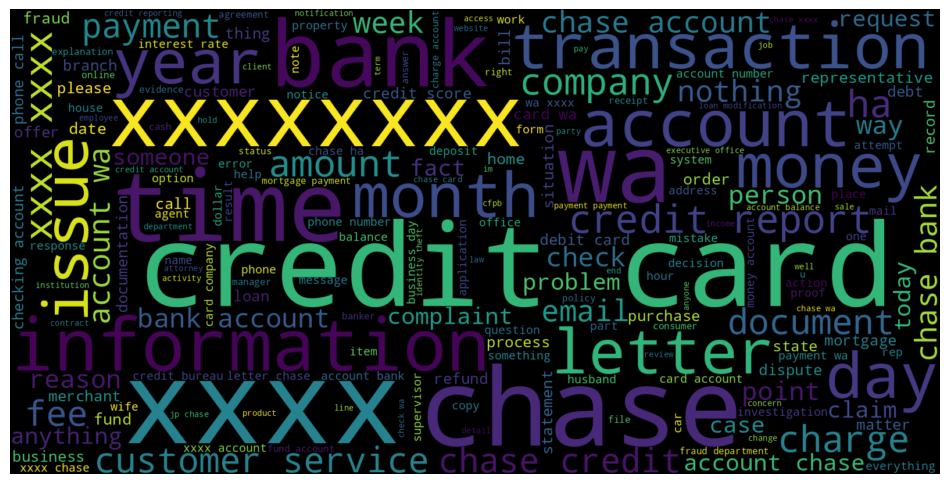

In [30]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

## Wordcloud of all corpus
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(all_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

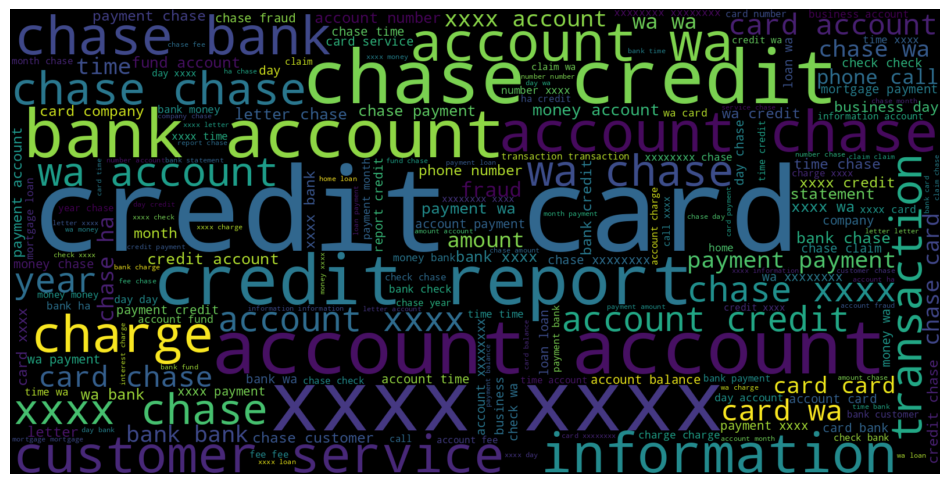

In [31]:

# Define  la ista de palabras top 40
top40 = list(top_40_df['Word'])

# Separa la cadena de todo el texto gigante en palabras individuales
palabras = all_text.split()

# Filtra las palabras que están en la lista "top40"
palabras_filtradas = [palabra for palabra in palabras if palabra in top40]

# Une las palabras filtradas para crear la nueva cadena
nueva_cadena = ' '.join(palabras_filtradas)

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(nueva_cadena)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [32]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

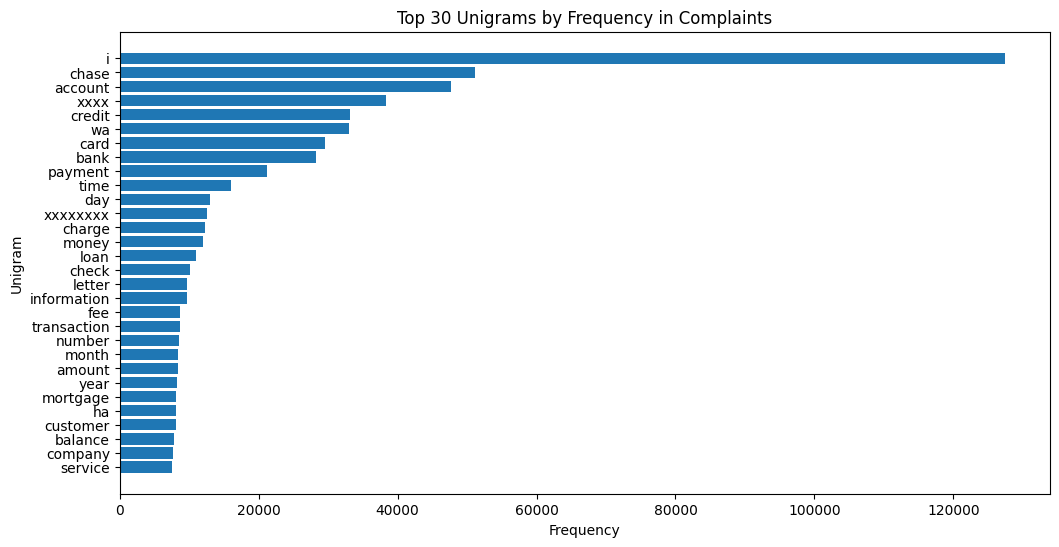

In [33]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
from collections import Counter

# Tokenize the cleaned text and create a list of words
all_words = ' '.join(df_clean['Complaint_clean']).split()

# Calculate word frequencies
word_freq = Counter(all_words)

# Get the top 30 unigrams by frequency
top_30_unigrams = word_freq.most_common(30)

# Create a DataFrame for visualization
top_30_unigrams_df = pd.DataFrame(top_30_unigrams, columns=['Unigram', 'Frequency'])

# Plot the top 30 unigrams
plt.figure(figsize=(12, 6))
plt.barh(top_30_unigrams_df['Unigram'], top_30_unigrams_df['Frequency'])
plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent unigrams at the top
plt.title('Top 30 Unigrams by Frequency in Complaints')
plt.xlabel('Frequency')
plt.ylabel('Unigram')
plt.show()


In [34]:
#Print the top 10 words in the unigram frequency
# Get the top 10 unigrams by frequency
top_10_unigrams = word_freq.most_common(10)

# Create a DataFrame for visualization
top_10_unigrams_df = pd.DataFrame(top_10_unigrams, columns=['Unigram', 'Frequency'])
top_10_unigrams_df.head(10)

,Unigram,Frequency
0,i,127478
1,chase,51080
2,account,47647
3,xxxx,38371
4,credit,33094
5,wa,32998
6,card,29587
7,bank,28233
8,payment,21167
9,time,16038


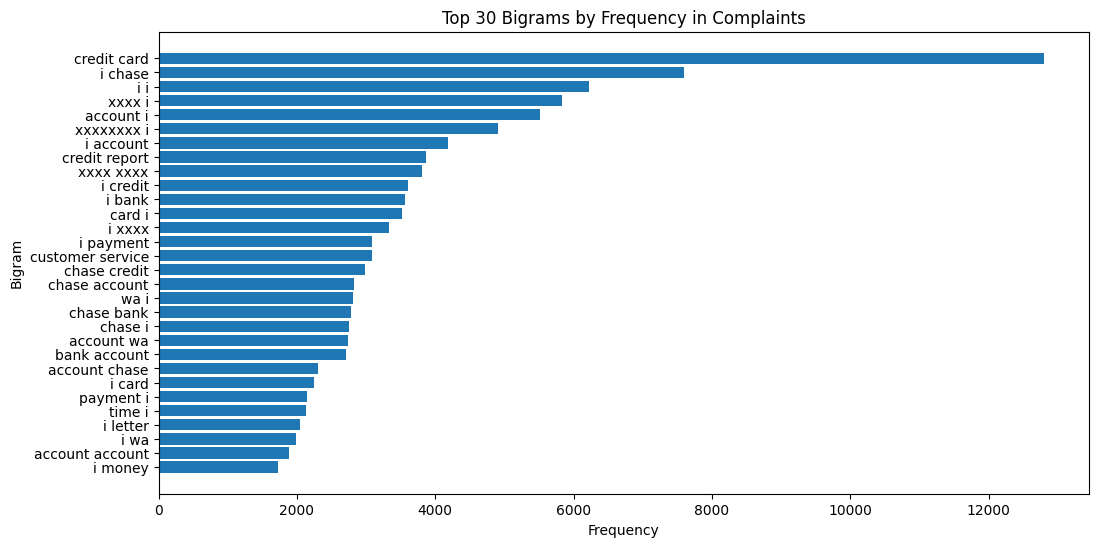

In [35]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned dataframe(df_clean).
from nltk.util import ngrams

# Tokenize the cleaned text into words
tokenized_text = df_clean['Complaint_clean'].str.split()

# Create a list of bigrams from the tokenized text
bigrams = [bigram for sublist in tokenized_text for bigram in list(ngrams(sublist, 2))]

# Calculate bigram frequencies
bigram_freq = Counter(bigrams)

# Get the top 30 bigrams by frequency
top_30_bigrams = bigram_freq.most_common(30)

# Create a DataFrame for visualization
top_30_bigrams_df = pd.DataFrame(top_30_bigrams, columns=['Bigram', 'Frequency'])

# Plot the top 30 bigrams
plt.figure(figsize=(12, 6))
plt.barh(top_30_bigrams_df['Bigram'].apply(lambda x: ' '.join(x)), top_30_bigrams_df['Frequency'])
plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent bigrams at the top
plt.title('Top 30 Bigrams by Frequency in Complaints')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()



In [36]:
#Print the top 10 words in the bigram frequency

# Get the top 10 bigrams by frequency
top_10_bigrams = bigram_freq.most_common(10)

# Create a DataFrame for visualization
top_10_bigrams_df = pd.DataFrame(top_10_bigrams, columns=['Bigram', 'Frequency'])
top_10_bigrams_df.head(10)

,Bigram,Frequency
0,"(credit, card)",12803
1,"(i, chase)",7600
2,"(i, i)",6220
3,"(xxxx, i)",5836
4,"(account, i)",5518
5,"(xxxxxxxx, i)",4903
6,"(i, account)",4191
7,"(credit, report)",3871
8,"(xxxx, xxxx)",3812
9,"(i, credit)",3603


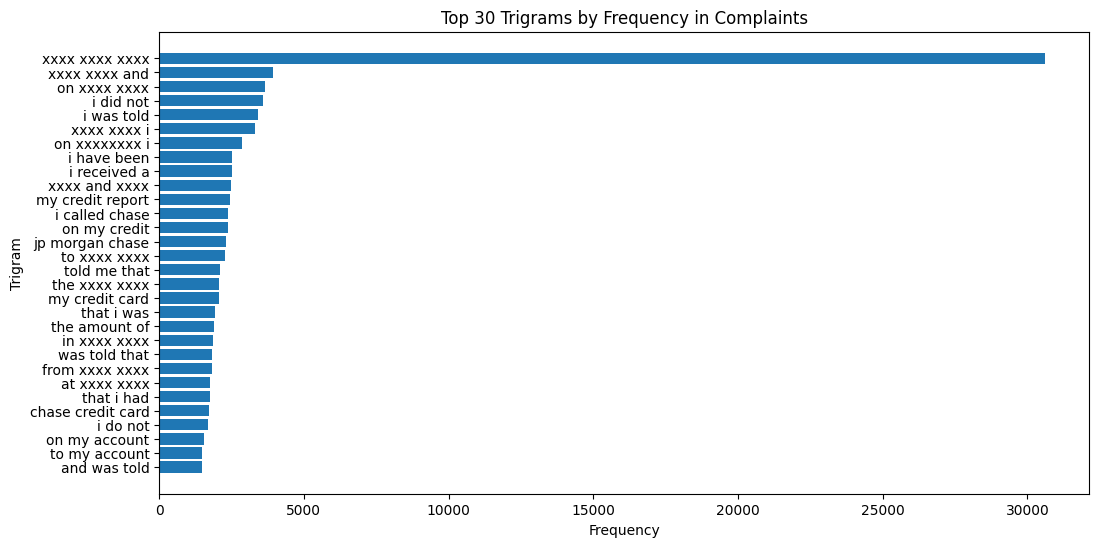

In [37]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned dataframe (df_clean).
# Tokenize the cleaned text into words
tokenized_text = df_clean['complaint'].str.split()

# Create a list of trigrams from the tokenized text
trigrams = [trigram for sublist in tokenized_text for trigram in list(ngrams(sublist, 3))]

# Calculate trigram frequencies
trigram_freq = Counter(trigrams)

# Get the top 30 trigrams by frequency
top_30_trigrams = trigram_freq.most_common(30)

# Create a DataFrame for visualization
top_30_trigrams_df = pd.DataFrame(top_30_trigrams, columns=['Trigram', 'Frequency'])

# Plot the top 30 trigrams
plt.figure(figsize=(12, 6))
plt.barh(top_30_trigrams_df['Trigram'].apply(lambda x: ' '.join(x)), top_30_trigrams_df['Frequency'])
plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent trigrams at the top
plt.title('Top 30 Trigrams by Frequency in Complaints')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.show()


In [38]:
#Print the top 10 words in the trigram frequency
# Get the top 10 trigrams by frequency
top_10_trigrams = trigram_freq.most_common(10)

# Create a DataFrame for visualization
top_10_trigrams_df = pd.DataFrame(top_10_trigrams, columns=['Trigram', 'Frequency'])
top_10_trigrams_df.head(10)

,Trigram,Frequency
0,"(xxxx, xxxx, xxxx)",30603
1,"(xxxx, xxxx, and)",3923
2,"(on, xxxx, xxxx)",3656
3,"(i, did, not)",3585
4,"(i, was, told)",3408
5,"(xxxx, xxxx, i)",3302
6,"(on, xxxxxxxx, i)",2857
7,"(i, have, been)",2529
8,"(i, received, a)",2507
9,"(xxxx, and, xxxx)",2483


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [39]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [40]:
#All masked texts has been removed
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,475,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,337,i card agent upgrade date agent wa information...
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,210,card wa application identity consent service c...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1433,book ticket i offer ticket card i information...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,456,son deposit chase account fund chase bank acco...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,650,chase card customer decade wa solicitation cre...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...,2067,i chas visa credit card provider claim purcha...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...,2296,i pay risk consumer i bank app chase year mobi...
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...,2009,i credit credit card chase freedom problem ba...


## Feature Extraction
Convierta los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [41]:
# Write your code here to initialise the TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Configura los parámetros max_df y min_df
max_df = 0.95  # Ignora términos que aparecen en más del 95% de los documentos
min_df = 2     # Ignora términos que aparecen en menos de 2 documentos

# Crea un vectorizador TF-IDF con los parámetros definidos
tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [42]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
# Ajusta y transforma tus datos sin procesar en una matriz TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])

# Access the non-zero elements of the TF-IDF matrix
complaint_ids, token_ids = tfidf_matrix.nonzero()
tfidf_scores = tfidf_matrix.data

# Create a list of tuples (complaint_id, token_id, tf-idf_score)
document_term_matrix = list(zip(complaint_ids.tolist(), token_ids.tolist(), tfidf_scores))

# Print the tuples (complaint_id, token_id, tf-idf_score)
for item in document_term_matrix:
    print(item)


Se han truncado las últimas 5000 líneas del flujo de salida.
(20909, 1555, 0.0960233424469914)
(20909, 3164, 0.12011426010327246)
(20909, 5437, 0.09787147683715067)
(20909, 1899, 0.11385803473087656)
(20909, 2764, 0.10559838403016358)
(20909, 1003, 0.19365766687043315)
(20909, 6388, 0.18913474130168334)
(20909, 3494, 0.06862418865567559)
(20909, 178, 0.07314169846458747)
(20909, 2061, 0.06907758047555172)
(20909, 290, 0.07487086697368193)
(20909, 3093, 0.14645749593888752)
(20909, 6463, 0.10871242493372991)
(20909, 5715, 0.07137165894601362)
(20909, 2257, 0.06830136219073163)
(20909, 6953, 0.07949337777731304)
(20909, 32, 0.06862418865567559)
(20909, 5244, 0.0673910515454076)
(20909, 2717, 0.05298949667590174)
(20909, 954, 0.05745533548639305)
(20909, 540, 0.05077242898627573)
(20909, 4721, 0.046852997164051016)
(20909, 108, 0.06375557701931082)
(20909, 5108, 0.06961396896463255)
(20909, 4445, 0.06697711563628138)
(20909, 6590, 0.27438827177988584)
(20909, 4032, 0.33638614263834815)
(2

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea tienes que realizar lo siguiente:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

* Encuentra el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)
* Corrija las etiquetas si es necesario
* Mapear el grupo de nombres de topicos/clusters

In [43]:
from sklearn.decomposition import NMF

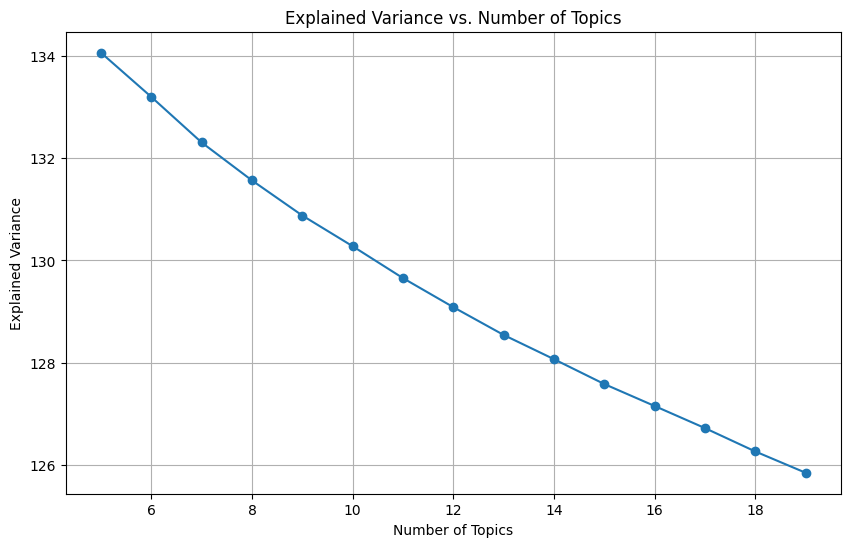

In [44]:
# Define a range of possible numbers of topics
num_topics_range = range(5, 20)  # You can adjust this range

# Store the explained variance for each number of topics
explained_variance = []

for num_topics in num_topics_range:
    # Create and fit the NMF model
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_model.fit(tfidf_matrix)

    # Calculate the explained variance (reconstruction error)
    reconstruction_error = nmf_model.reconstruction_err_
    explained_variance.append(reconstruction_error)

# Plot the explained variance as a function of the number of topics
plt.figure(figsize=(10, 6))
plt.plot(num_topics_range, explained_variance, marker='o')
plt.title('Explained Variance vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Explained Variance')
plt.grid()
plt.show()


## Manual Topic Modeling
Debe adoptar el enfoque de prueba y error para encontrar la mejor cantidad de topicos para su modelo NMF.

El único parámetro que se requiere es el número de componentes, es decir, el número de topicos que queremos. Este es el paso más crucial en todo el proceso de modelado de topicos y afectará en gran medida la calidad de sus topicos finales.

In [45]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [46]:
x = nmf_model.fit(tfidf_matrix)
feature_names =tfidf_vectorizer.get_feature_names_out()
len(feature_names)

7124

In [47]:
print(feature_names)

['__' '___' '____' ... 'zipcode' 'zombie' 'zone']


In [48]:
#Print the Top15 words for each of the topics
num_top_words = 15
# Get the topic-word matrices from the NMF model
topic_word_matrix = nmf_model.components_
# Print the top words for each topic
for topic_idx, topic in enumerate(topic_word_matrix):
    top_words_idx = topic.argsort()[-num_top_words:][::-1]  # Get indices of top words
    top_words = [feature_names[i] for i in top_words_idx]  # Get top words
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: account, bank, check, money, fund, chase, wa, deposit, branch, day, fee, checking, business, number, customer
Topic 2: card, credit, chase, balance, account, fee, interest, limit, year, score, month, point, wa, purchase, offer
Topic 3: payment, loan, mortgage, chase, month, modification, home, interest, wa, time, year, rate, balance, amount, property
Topic 4: inquiry, report, credit, bureau, company, information, reporting, debt, identity, score, theft, letter, jpmcb, application, account
Topic 5: charge, transaction, chase, dispute, claim, wa, fraud, merchant, letter, phone, information, time, service, number, call


In [49]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
# Assign the best topic (integer value) to each complaint
best_topics = [topic.argmax() for topic in topic_word_matrix]

# Print the best topic assignments
for i, best_topic in enumerate(best_topics):
    print(f"Topic {i + 1} is assigned to Complaint {best_topic}")


Topic 1 is assigned to Complaint 46
Topic 2 is assigned to Complaint 928
Topic 3 is assigned to Complaint 4628
Topic 4 is assigned to Complaint 3386
Topic 5 is assigned to Complaint 1054


In [50]:
print(best_topics)


[46, 928, 4628, 3386, 1054]


In [51]:
#Assign the best topic to each of the complaints in Topic Column
# Transform the TF-IDF matrix into topic vectors
topic_vectors = nmf_model.transform(tfidf_matrix)

# Assign the best topic (integer value) to each complaint
df_clean['Topic'] = [topic.argmax() for topic in topic_vectors]


In [52]:
print(df_clean)

                                               complaint  \
1      good morning my name is xxxx xxxx and i apprec...   
2      i upgraded my xxxx xxxx card in  and was told ...   
10     chase card was reported on  however fraudulent...   
11     on  while trying to book a xxxx  xxxx  ticket ...   
14     my grand son give me check for  i deposit it i...   
...                                                  ...   
78303  after being a chase card customer for well ove...   
78309  on wednesday xxxxxxxx i called chas my xxxx xx...   
78310  i am not familiar with xxxx pay and did not un...   
78311  i have had flawless credit for  yrs ive had ch...   
78312  roughly  years ago i closed out my accounts wi...   

                                    lemmatized_complaint  \
1      good morning my name is xxxx xxxx and i apprec...   
2      i upgraded my xxxx xxxx card in and wa told by...   
10     chase card wa reported on however fraudulent a...   
11     on while trying to book a xxxx x

In [54]:
print(df_clean)

                                               complaint  \
1      good morning my name is xxxx xxxx and i apprec...   
2      i upgraded my xxxx xxxx card in  and was told ...   
10     chase card was reported on  however fraudulent...   
11     on  while trying to book a xxxx  xxxx  ticket ...   
14     my grand son give me check for  i deposit it i...   
...                                                  ...   
78303  after being a chase card customer for well ove...   
78309  on wednesday xxxxxxxx i called chas my xxxx xx...   
78310  i am not familiar with xxxx pay and did not un...   
78311  i have had flawless credit for  yrs ive had ch...   
78312  roughly  years ago i closed out my accounts wi...   

                                    lemmatized_complaint  \
1      good morning my name is xxxx xxxx and i apprec...   
2      i upgraded my xxxx xxxx card in and wa told by...   
10     chase card wa reported on however fraudulent a...   
11     on while trying to book a xxxx x

In [55]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaint              21072 non-null  object
 1   lemmatized_complaint   21072 non-null  object
 2   complaint_POS_removed  21072 non-null  object
 3   complaint_length       21072 non-null  int64 
 4   Complaint_clean        21072 non-null  object
 5   Topic                  21072 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


In [57]:
df_clean.head(5)

,complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,475,morning name stop bank cardmember service debt...,0
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,337,i card agent upgrade date agent wa information...,1
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,210,card wa application identity consent service c...,1
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1433,book ticket i offer ticket card i information...,3
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,456,son deposit chase account fund chase bank acco...,0


In [95]:
df_copia = df_clean.copy()
df_copia.head(5)

,complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,475,morning name stop bank cardmember service debt...,0
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,337,i card agent upgrade date agent wa information...,1
10,chase card was reported on however fraudulent...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,210,card wa application identity consent service c...,1
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1433,book ticket i offer ticket card i information...,3
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,456,son deposit chase account fund chase bank acco...,0


In [96]:
df_copia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaint              21072 non-null  object
 1   lemmatized_complaint   21072 non-null  object
 2   complaint_POS_removed  21072 non-null  object
 3   complaint_length       21072 non-null  int64 
 4   Complaint_clean        21072 non-null  object
 5   Topic                  21072 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [65]:
'''#Create the dictionary of Topic names and Topics

Topic_names = {
    0: "Bank Account Services",
    1: "Credit Card or Prepaid Card",
    2: "Theft/Dispute Reporting",
    3: "Mortgage/Loan",
    4: "Others"
}
#Replace Topics with Topic Names
df_copia['Topic'] = df_copia['Topic'].map(Topic_names)'''

In [89]:
df_copia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaint              21072 non-null  object
 1   lemmatized_complaint   21072 non-null  object
 2   complaint_POS_removed  21072 non-null  object
 3   complaint_length       21072 non-null  int64 
 4   Complaint_clean        21072 non-null  object
 5   Topic                  21072 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


## Supervised model to predict any new complaints to the relevant Topics.

Hasta ahora ha creado el modelo para crear los temas para cada queja. Entonces, en la siguiente sección, los utilizará para clasificar cualquier queja nueva.

Dado que utilizará la técnica de aprendizaje supervisado, tenemos que convertir los nombres de los temas en números (las matrices numpy solo entienden los números)

In [90]:
X = df_copia[['complaint', 'lemmatized_complaint', 'complaint_POS_removed', 'Complaint_clean']]
y = df_copia['Topic']

In [92]:
# Vectorización de texto
count_vectorizer = CountVectorizer(max_features=1000)  # Puedes ajustar el número máximo de características
X_bow = count_vectorizer.fit_transform(X)

In [97]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Selecciona las características y el objetivo
X = df_copia[['complaint', 'lemmatized_complaint', 'complaint_POS_removed', 'Complaint_clean']]
y = df_copia['Topic']

# Concatenar todas las columnas de texto en una sola columna
X['text'] = X.apply(lambda row: ' '.join(row), axis=1)

# Vectorización de texto
count_vectorizer = CountVectorizer(max_features=1000)  # Puedes ajustar el número máximo de características
X_bow = count_vectorizer.fit_transform(X['text'])

# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

Accuracy: 0.9473309608540925
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1046
           1       0.94      0.95      0.95       812
           2       0.96      0.96      0.96      1003
           3       0.93      0.95      0.94       422
           4       0.94      0.93      0.93       932

    accuracy                           0.95      4215
   macro avg       0.95      0.95      0.95      4215
weighted avg       0.95      0.95      0.95      4215



#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [101]:
# Calcular métricas
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Cambiar a weighted
    recall = recall_score(y_true, y_pred, average='weighted')  # Cambiar a weighted
    f1 = f1_score(y_true, y_pred, average='weighted')  # Cambiar a weighted
    confusion = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, confusion


In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Crear modelos
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

# Entrenar modelos
logistic_regression.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

# Realizar predicciones
logistic_regression_preds = logistic_regression.predict(X_test)
decision_tree_preds = decision_tree.predict(X_test)
random_forest_preds = random_forest.predict(X_test)

In [103]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)
naive_bayes_preds = naive_bayes.predict(X_test)

In [102]:
logistic_regression_metrics = calculate_metrics(y_test, logistic_regression_preds)
decision_tree_metrics = calculate_metrics(y_test, decision_tree_preds)
random_forest_metrics = calculate_metrics(y_test, random_forest_preds)

# Imprimir métricas
print("Logistic Regression Metrics:")
print("Accuracy:", logistic_regression_metrics[0])
print("Precision:", logistic_regression_metrics[1])
print("Recall:", logistic_regression_metrics[2])
print("F1 Score:", logistic_regression_metrics[3])
print("Confusion Matrix:")
print(logistic_regression_metrics[4])

print("\nDecision Tree Metrics:")
print("Accuracy:", decision_tree_metrics[0])
print("Precision:", decision_tree_metrics[1])
print("Recall:", decision_tree_metrics[2])
print("F1 Score:", decision_tree_metrics[3])
print("Confusion Matrix:")
print(decision_tree_metrics[4])

print("\nRandom Forest Metrics:")
print("Accuracy:", random_forest_metrics[0])
print("Precision:", random_forest_metrics[1])
print("Recall:", random_forest_metrics[2])
print("F1 Score:", random_forest_metrics[3])
print("Confusion Matrix:")
print(random_forest_metrics[4])

Logistic Regression Metrics:
Accuracy: 0.9473309608540925
Precision: 0.9474094032727542
Recall: 0.9473309608540925
F1 Score: 0.9473431135241073
Confusion Matrix:
[[989  11  16   6  24]
 [  8 775   4  13  12]
 [  9  12 958   6  18]
 [  3   8   5 401   5]
 [ 26  19  14   3 870]]

Decision Tree Metrics:
Accuracy: 0.7758007117437722
Precision: 0.7760638609916487
Recall: 0.7758007117437722
F1 Score: 0.7758276286056192
Confusion Matrix:
[[816  54  39  23 114]
 [ 41 641  24  24  82]
 [ 50  33 839  24  57]
 [ 20  29  19 333  21]
 [121  90  60  20 641]]

Random Forest Metrics:
Accuracy: 0.8567022538552788
Precision: 0.8576838068566534
Recall: 0.8567022538552788
F1 Score: 0.8561179333002843
Confusion Matrix:
[[936  34  27  10  39]
 [ 21 687  22  11  71]
 [ 27  37 917   3  19]
 [ 17  36  33 327   9]
 [108  31  46   3 744]]


In [104]:
naive_bayes_metrics = calculate_metrics(y_test, naive_bayes_preds)

print("\nNaive Bayes Metrics:")
print("Accuracy:", naive_bayes_metrics[0])
print("Precision:", naive_bayes_metrics[1])
print("Recall:", naive_bayes_metrics[2])
print("F1 Score:", naive_bayes_metrics[3])
print("Confusion Matrix:")
print(naive_bayes_metrics[4])


Naive Bayes Metrics:
Accuracy: 0.8227758007117437
Precision: 0.8306695758799734
Recall: 0.8227758007117437
F1 Score: 0.8239853241938772
Confusion Matrix:
[[904  43  34  35  30]
 [ 23 638  14  71  66]
 [ 32  90 830  36  15]
 [  1  26  11 383   1]
 [ 90  50  38  41 713]]


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)


# Resultados

Logistic Regression Metrics:
* Accuracy: 0.9473309608540925
* Precision: 0.9474094032727542
* Recall: 0.9473309608540925
* F1 Score: 0.9473431135241073

Decision Tree Metrics:
* Accuracy: 0.7758007117437722
* Precision: 0.7760638609916487
* Recall: 0.7758007117437722
* F1 Score: 0.7758276286056192

Random Forest Metrics:
* Accuracy: 0.8567022538552788
* Precision: 0.8576838068566534
* Recall: 0.8567022538552788
* F1 Score: 0.8561179333002843

Naive Bayes Metrics:
* Accuracy: 0.8227758007117437
* Precision: 0.8306695758799734
* Recall: 0.8227758007117437
* F1 Score: 0.8239853241938772

Siendo el mejor modelo el de Logistic Regression
